In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import random
from nltk.corpus import stopwords

In [5]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [6]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Shuffling and writing examples to /Users/zhuochaozhong/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5I62E0/imdb_reviews-train.tfrecord


Shuffling and writing examples to /Users/zhuochaozhong/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5I62E0/imdb_reviews-test.tfrecord


Shuffling and writing examples to /Users/zhuochaozhong/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5I62E0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /Users/zhuochaozhong/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [8]:
dataset['train']

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [12]:
encoder = info.features['text'].encoder

In [19]:
encoder.encode('Hello')

[4025, 8040]

In [22]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [24]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

In [38]:
train_dataset

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [39]:
import glob

In [40]:
%pwd

'/Users/zhuochaozhong/Documents/GitHub/BBC-Classification'

In [150]:
STOPWORDS = set(stopwords.words('english'))

In [193]:
bbc_dir = 'bbc-2/'
categories = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

news_text = []
news_label = []

for label, idx in categories.items():
    
    print('Processing category: %s (%d)' % (label, idx))
    
    for file_name in glob.glob(bbc_dir + label + '/*.txt'):
        with open(file_name, 'r', encoding="utf8", errors='ignore') as news_file:
            text = news_file.read()
            
#             for word in STOPWORDS:
#                 text = text.replace(word, '')
            
        news_text.append([text, idx])
random.shuffle(news_text)

Processing category: business (0)
Processing category: entertainment (1)
Processing category: politics (2)
Processing category: sport (3)
Processing category: tech (4)


In [194]:
text = [text[0] for text in news_text]
label = [label[1] for label in news_text]

In [195]:
train_size = int(len(news_text) * 0.8)

train_articles = text[0: train_size]
train_labels = label[0: train_size]

validation_articles = text[train_size:]
validation_labels = label[train_size:]

In [196]:
print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


In [197]:
tokenizer = Tokenizer(5000, oov_token='<oov>')

In [198]:
tokenizer.fit_on_texts(train_articles)

In [199]:
train_seq = tokenizer.texts_to_sequences(train_articles)

In [200]:
test_seq = tokenizer.texts_to_sequences(validation_articles)

In [201]:
train_pad = pad_sequences(train_seq, maxlen=300, padding='post', truncating='post')

In [202]:
test_pad = pad_sequences(test_seq, maxlen=300, padding='post', truncating='post')

In [203]:
train_labels = np.array(train_labels)

In [204]:
train_labels = train_labels.reshape(1780, 1)

In [205]:
test_labels = np.array(validation_labels)

In [206]:
test_labels = test_labels.reshape(445,1)

In [124]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_pad[10]))
print('---')
print(train_articles[10])

broadband challenges tv viewing the number of europeans with broadband has <oov> over the past 12 months with the web eating into tv viewing <oov> research suggests just over 54 million people are <oov> up to the net via broadband up from 34 million a year ago according to market analysts <oov> <oov> the total number of people online in europe has broken the 100 million mark the popularity of the net has meant that many are turning away from tv say analysts <oov> research it found that a quarter of web users said they spent less time watching tv in favour of the net the report by <oov> <oov> found that the number of people with fast internet access had risen by 60 over the past year the biggest jump was in italy where it rose by 120 britain was close behind with broadband users almost <oov> in a year the growth has been fuelled by lower prices and a wider choice of always on fast net subscription plans <oov> months ago high speed internet users made up just over one third of the audien

In [207]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [208]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [209]:
history = model.fit(train_pad, train_labels, epochs=5, validation_data=(test_pad, test_labels), verbose=2)

Epoch 1/5
56/56 - 19s - loss: 1.4708 - accuracy: 0.3034 - val_loss: 1.1999 - val_accuracy: 0.5303
Epoch 2/5
56/56 - 18s - loss: 0.7169 - accuracy: 0.7388 - val_loss: 0.3996 - val_accuracy: 0.8697
Epoch 3/5
56/56 - 27s - loss: 0.2127 - accuracy: 0.9489 - val_loss: 0.3735 - val_accuracy: 0.9056
Epoch 4/5
56/56 - 31s - loss: 0.0847 - accuracy: 0.9809 - val_loss: 0.3067 - val_accuracy: 0.9124
Epoch 5/5
56/56 - 19s - loss: 0.0501 - accuracy: 0.9888 - val_loss: 0.4564 - val_accuracy: 0.8899


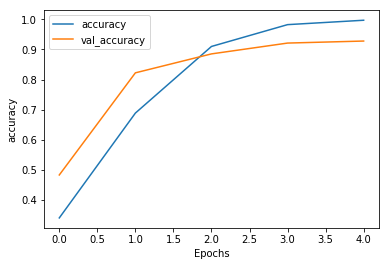

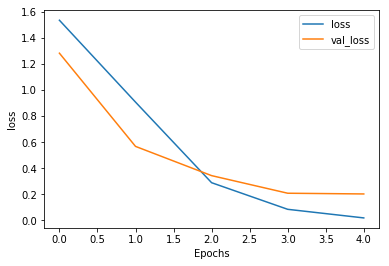

In [148]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

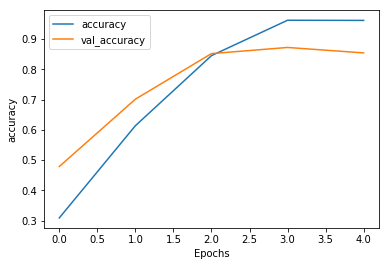

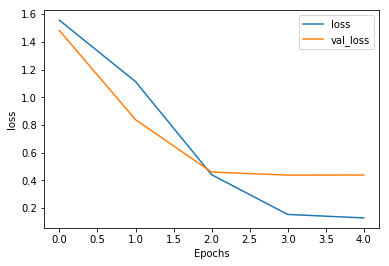

In [187]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")